<a href="https://colab.research.google.com/github/Maxsaro/CATIJR/blob/main/03_EDA_numericas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02_EDA_numericas

Este notebook realiza a análise exploratória das **variáveis numéricas** do dataset de preços de casas.

Objetivos principais:
- Documentar o significado de cada variável numérica.
- Analisar a correlação com `SalePrice`.
- Visualizar relações com gráficos de dispersão e boxplots.
- Identificar outliers com base no z-score aplicado ao log1p do preço.
- Avaliar valores nulos e possíveis estratégias de replace.
- Destacar a relevância das variáveis.


## 1. Carregamento e preparação dos dados

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.rcParams['figure.figsize'] = (10,6)
sns.set(style='whitegrid')

url = 'https://raw.githubusercontent.com/thalestirapani/Projeto-House-Prices-CATI-Jr./refs/heads/main/data/raw/train.csv?token=GHSAT0AAAAAADNV2AHHZITK4E3QGAEAKRMY2HY7JEA'
df = pd.read_csv(url)

df = df.drop(columns=['Id'])
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
categorical_cols = df.select_dtypes(include="object").columns.tolist()
print(f"Total de variáveis categóricas: {len(categorical_cols)}")
print(categorical_cols)

Total de variáveis categóricas: 43
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


## 2. Descrição das variáveis categóricas

Abaixo segue o significado de cada variável categórica presente no dataset.

- **MSZoning**: Classificação geral de zoneamento da propriedade (ex.: RL = residencial baixa densidade, RM = média densidade).  
  *Relevância:* Alta — afeta diretamente o valor por refletir o tipo de área permitida para construção.  

- **Street**: Tipo de via de acesso à propriedade (Grvl = cascalho, Pave = pavimentada).  
  *Relevância:* Baixa a média — ruas pavimentadas tendem a valorizar levemente o imóvel.  

- **Alley**: Tipo de acesso lateral (Grvl, Pave ou NaN = sem acesso).  
  *Relevância:* Baixa — muitos valores ausentes (>90%).  

- **LotShape**: Forma geral do lote (Reg = regular, IR1–IR3 = irregular).  
  *Relevância:* Média — influencia o aproveitamento do terreno.  

- **LandContour**: Nivelamento do terreno (Lvl = plano, HLS = colina, etc.).  
  *Relevância:* Média — terrenos planos geralmente são mais valorizados.  

- **Utilities**: Serviços públicos disponíveis (AllPub, NoSewr, etc.).  
  *Relevância:* Baixa — quase todas as casas têm os mesmos serviços (baixa variabilidade).  

- **LotConfig**: Configuração do lote (Inside, Corner, CulDSac, etc.).  
  *Relevância:* Média — esquinas e cul-de-sac tendem a ter leve valorização.  

- **LandSlope**: Declive do terreno (Gtl = suave, Mod = moderado, Sev = acentuado).  
  *Relevância:* Baixa a média.  

- **Neighborhood**: Bairro ou localização física dentro da cidade.  
  *Relevância:* Muito alta — um dos fatores mais importantes para o preço.  

- **Condition1**: Proximidade de vias principais ou ferrovias (Artery, Feedr, RRNear, etc.).  
  *Relevância:* Média — ruído ou tráfego podem reduzir valor.  

- **Condition2**: Segunda condição especial (quando há mais de uma proximidade).  
  *Relevância:* Média a baixa.  

- **BldgType**: Tipo de construção (1Fam, 2fmCon, Duplex, Twnhs, TwnhsE).  
  *Relevância:* Alta — casas individuais geralmente mais caras.  

- **HouseStyle**: Estilo arquitetônico (1Story, 2Story, SLvl, SFoyer, etc.).  
  *Relevância:* Alta — estilos influenciam layout e valor.  

- **RoofStyle**: Tipo de telhado (Gable, Hip, Flat, etc.).  
  *Relevância:* Baixa — pouca variação de preço.  

- **RoofMatl**: Material do telhado (CompShg, Metal, Tar&Grv, etc.).  
  *Relevância:* Baixa — quase constante.  

- **Exterior1st**: Material de revestimento externo principal.  
  *Relevância:* Média — indica qualidade e custo do acabamento.  

- **Exterior2nd**: Segundo material de revestimento externo.  
  *Relevância:* Média.  

- **MasVnrType**: Tipo de revestimento em alvenaria (BrkFace, Stone, None, etc.).  
  *Relevância:* Média — estética e custo de construção.  

- **ExterQual**: Qualidade do material exterior (Ex, Gd, TA, Fa, Po).  
  *Relevância:* Alta — está fortemente correlacionada com o preço.  

- **ExterCond**: Condição do material exterior.  
  *Relevância:* Média — impacto menor que a qualidade.  

- **Foundation**: Tipo de fundação (PConc, CBlock, Slab, etc.).  
  *Relevância:* Média — fundações mais modernas tendem a agregar valor.  

- **BsmtQual**: Qualidade geral do porão.  
  *Relevância:* Alta — porões bem acabados aumentam o valor.  

- **BsmtCond**: Condição geral do porão.  
  *Relevância:* Média.  

- **BsmtExposure**: Nível de exposição do porão (walkout, garden level, etc.).  
  *Relevância:* Alta — influencia luminosidade e valor.  

- **BsmtFinType1**: Tipo de acabamento do porão (GLQ, ALQ, BLQ, Rec, etc.).  
  *Relevância:* Alta.  

- **BsmtFinType2**: Segundo tipo de acabamento do porão.  
  *Relevância:* Média.  

- **Heating**: Tipo de aquecimento (GasA, GasW, Grav, Wall, etc.).  
  *Relevância:* Baixa a média.  

- **HeatingQC**: Qualidade do sistema de aquecimento.  
  *Relevância:* Alta — afeta conforto e eficiência energética.  

- **CentralAir**: Indica se possui ar-condicionado central (Y/N).  
  *Relevância:* Alta — conforto térmico influencia o preço.  

- **Electrical**: Sistema elétrico (SBrkr, FuseA, etc.).  
  *Relevância:* Baixa — quase constante.  

- **KitchenQual**: Qualidade da cozinha.  
  *Relevância:* Muito alta — fortemente associada ao valor de venda.  

- **Functional**: Funcionalidade geral da casa (Typ, Min1, Mod, etc.).  
  *Relevância:* Média — afeta levemente o valor.  

- **FireplaceQu**: Qualidade da lareira.  
  *Relevância:* Média — impacto estético, mas muitos valores ausentes.  

- **GarageType**: Localização da garagem (Attchd, Detchd, BuiltIn, etc.).  
  *Relevância:* Alta — influência prática e de conveniência.  

- **GarageFinish**: Nível de acabamento interno da garagem.  
  *Relevância:* Média.  

- **GarageQual**: Qualidade da garagem.  
  *Relevância:* Alta.  

- **GarageCond**: Condição da garagem.  
  *Relevância:* Média.  

- **PavedDrive**: Entrada pavimentada (Y, P, N).  
  *Relevância:* Média — imóveis com acesso pavimentado são mais valorizados.  

- **PoolQC**: Qualidade da piscina.  
  *Relevância:* Baixa — poucas casas têm piscina (quase todos NaN).  

- **Fence**: Tipo de cerca.  
  *Relevância:* Baixa — muitos valores ausentes.  

- **MiscFeature**: Outras características não listadas (Shed, TenC, etc.).  
  *Relevância:* Baixa — raramente preenchida.  

- **SaleType**: Tipo de venda (WD, New, COD, ConLD, etc.).  
  *Relevância:* Média — afeta preço por tipo de transação.  

- **SaleCondition**: Condição da venda (Normal, Abnorml, Partial, etc.).  
  *Relevância:* Alta — casas novas (“Partial”) tendem a ter preço maior.  

## 3. Frequencia de cada variável

In [ ]:
for col in categorical_cols:
    print(f"\n📊 {col}")
    print(df[col].value_counts(dropna=False))
    print("-" * 60)


📊 MSZoning
MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64
------------------------------------------------------------

📊 Street
Street
Pave    1454
Grvl       6
Name: count, dtype: int64
------------------------------------------------------------

📊 Alley
Alley
NaN     1369
Grvl      50
Pave      41
Name: count, dtype: int64
------------------------------------------------------------

📊 LotShape
LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64
------------------------------------------------------------

📊 LandContour
LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64
------------------------------------------------------------

📊 Utilities
Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64
------------------------------------------------------------

📊 LotConfig
LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47


## 4. Boxplot com o SalePrice

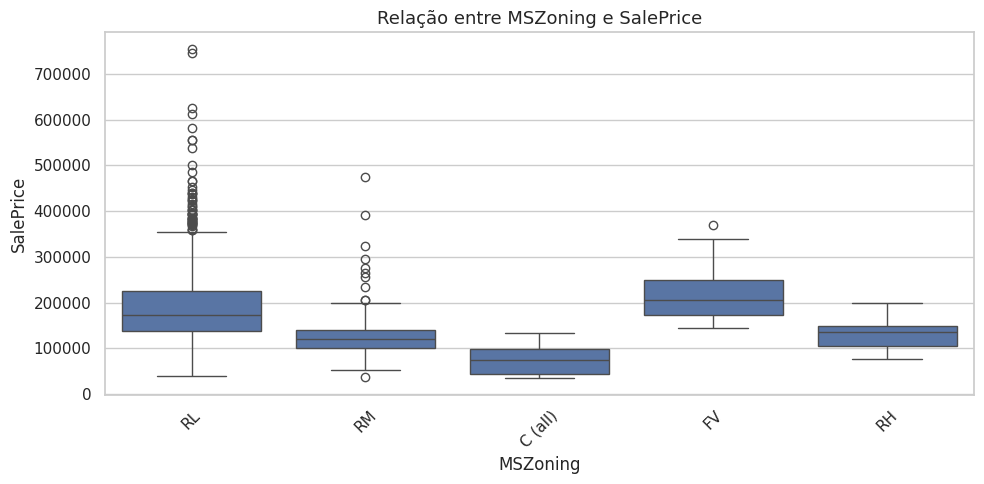

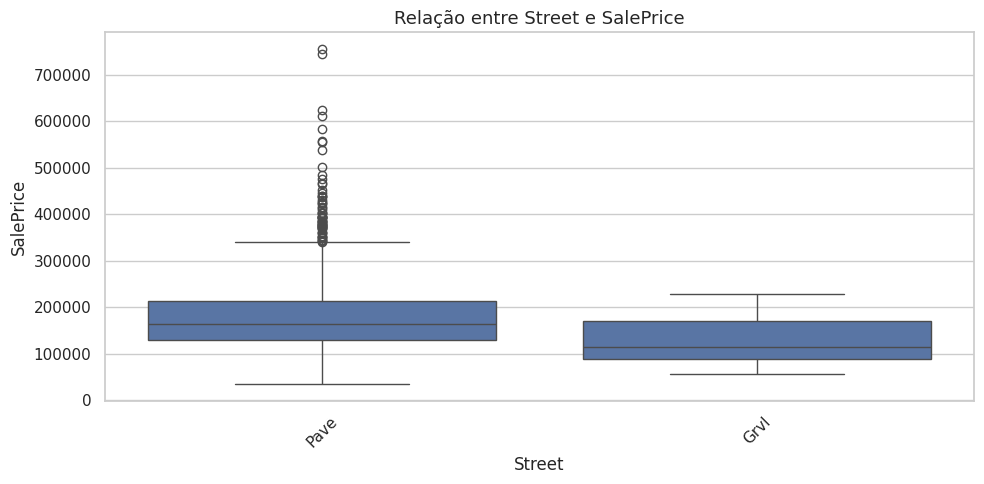

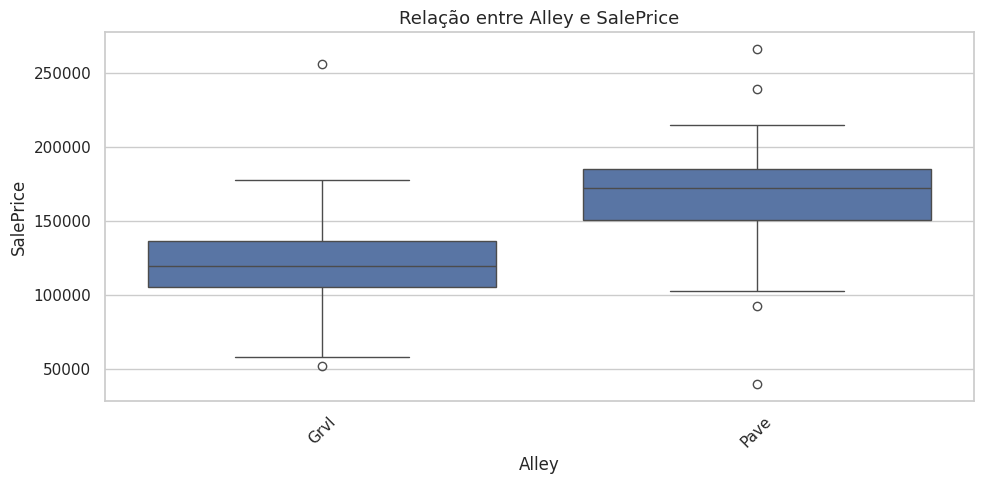

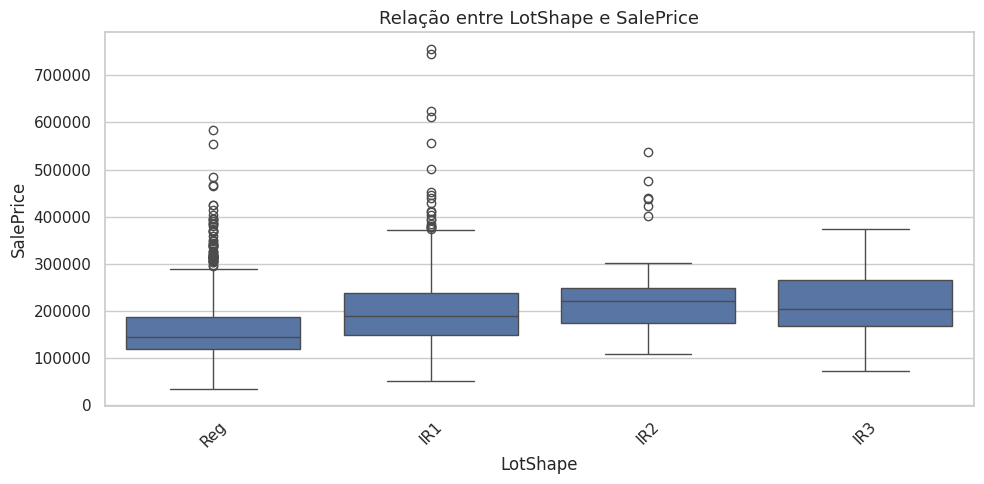

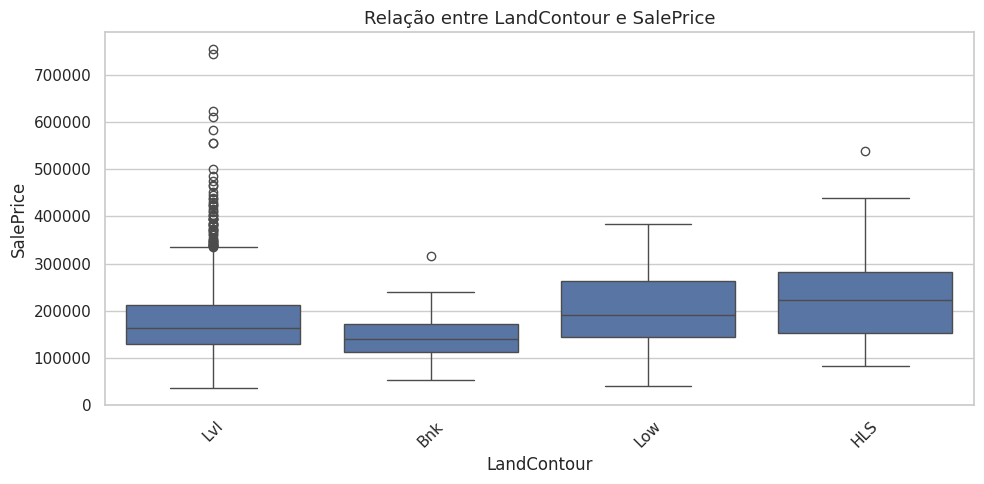

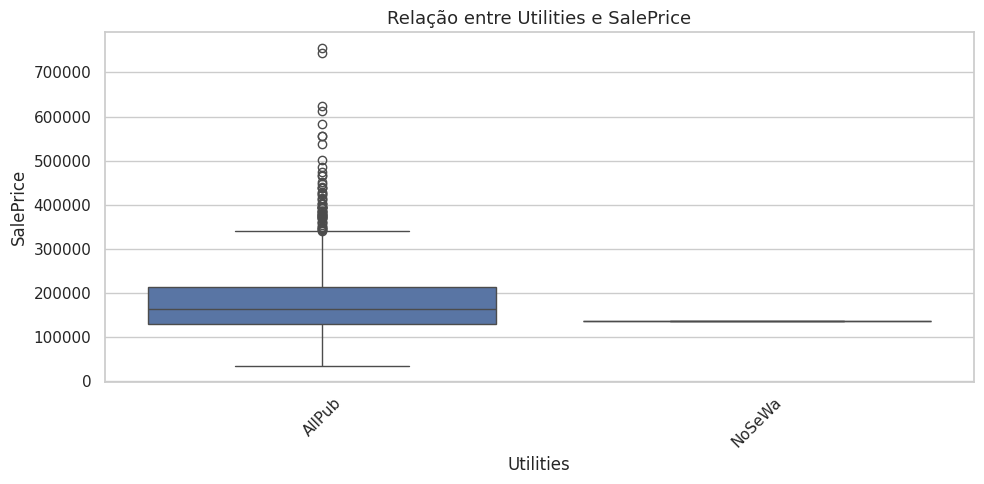

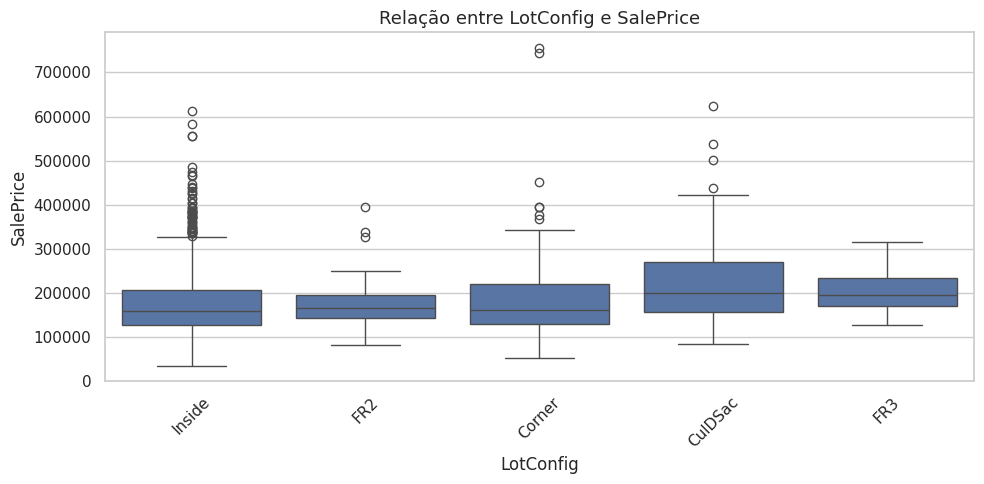

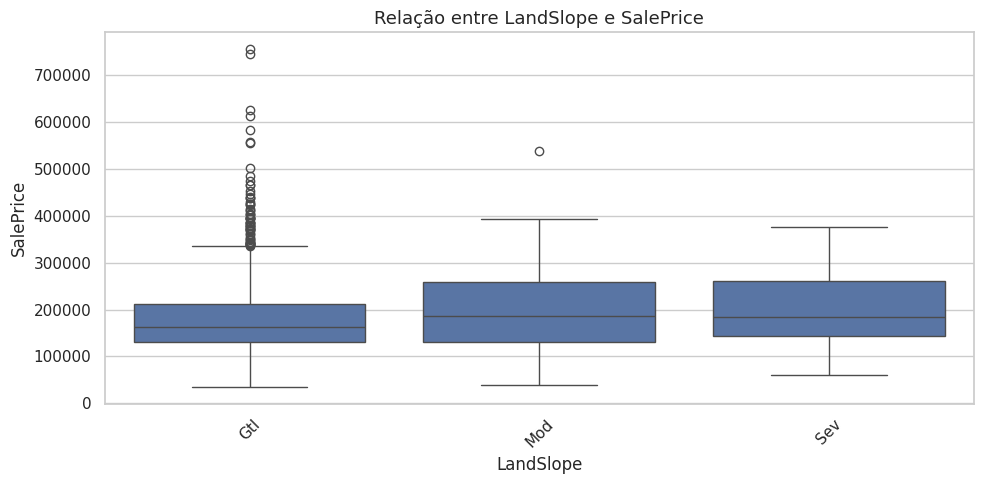

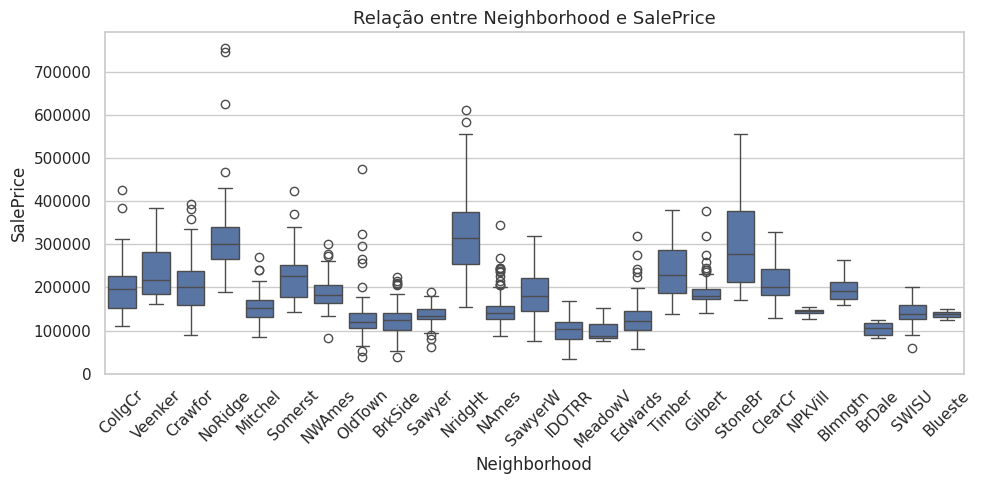

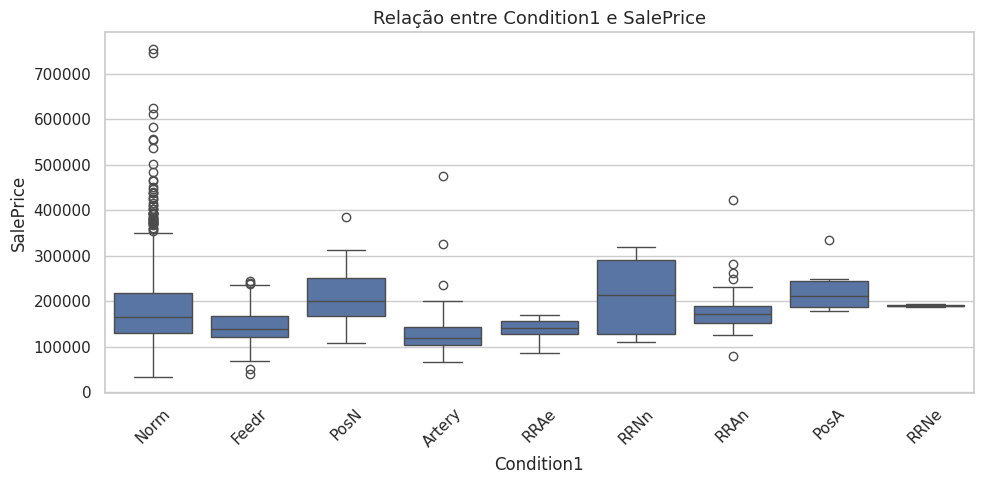

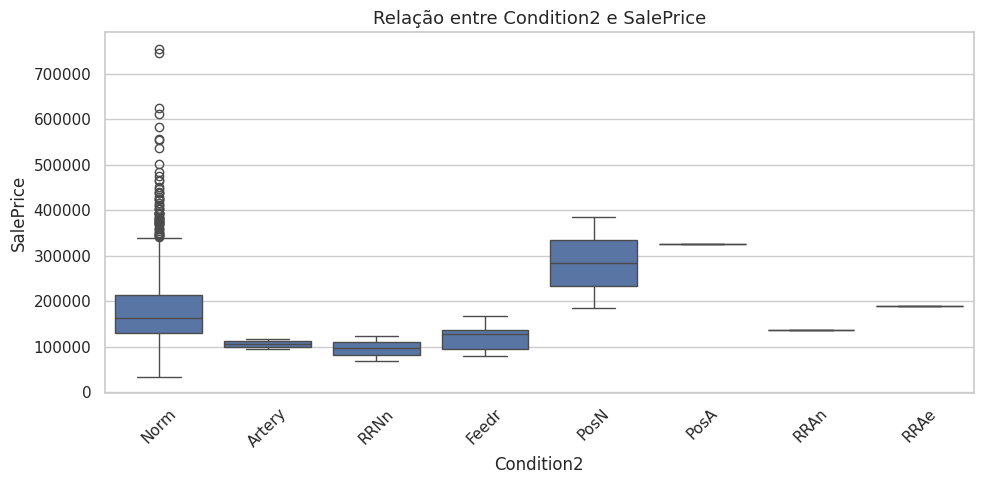

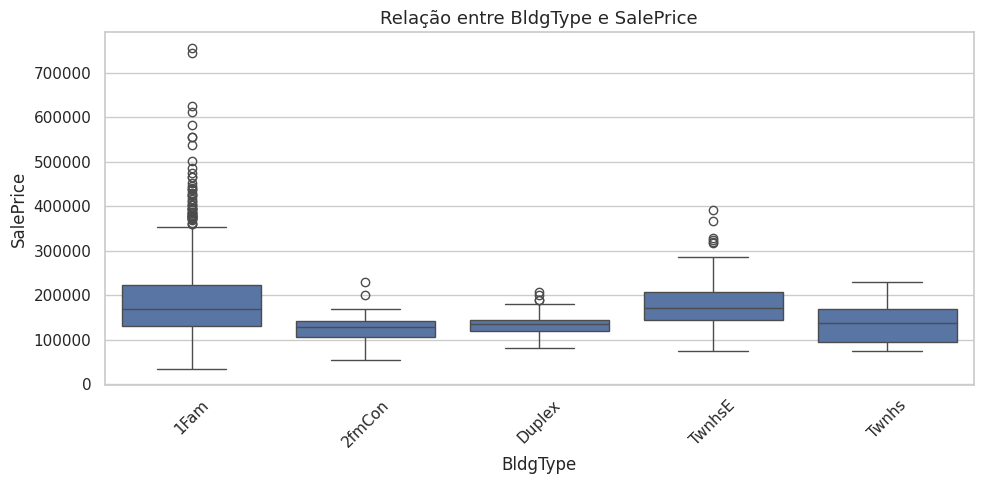

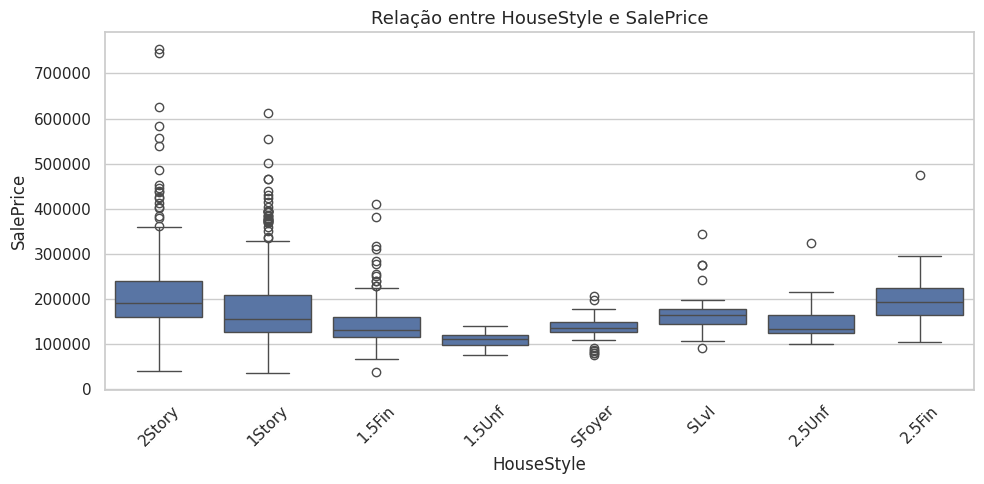

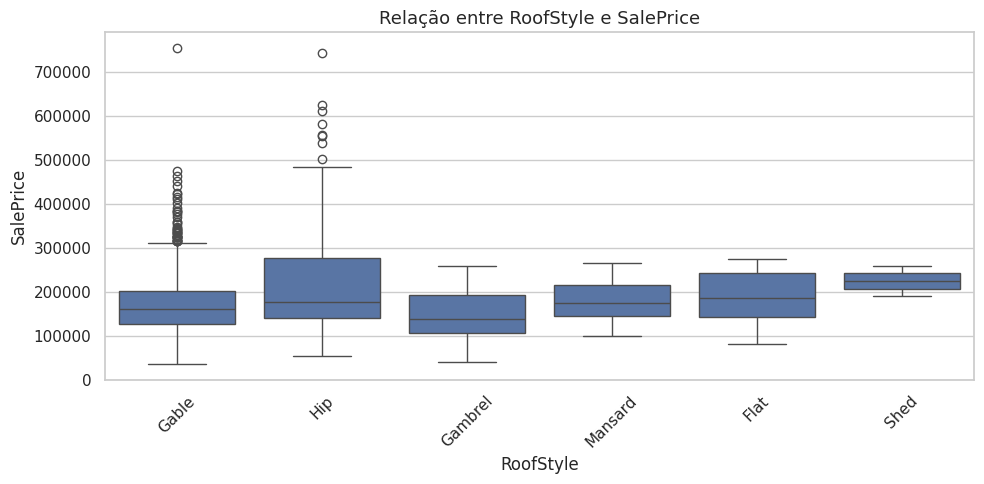

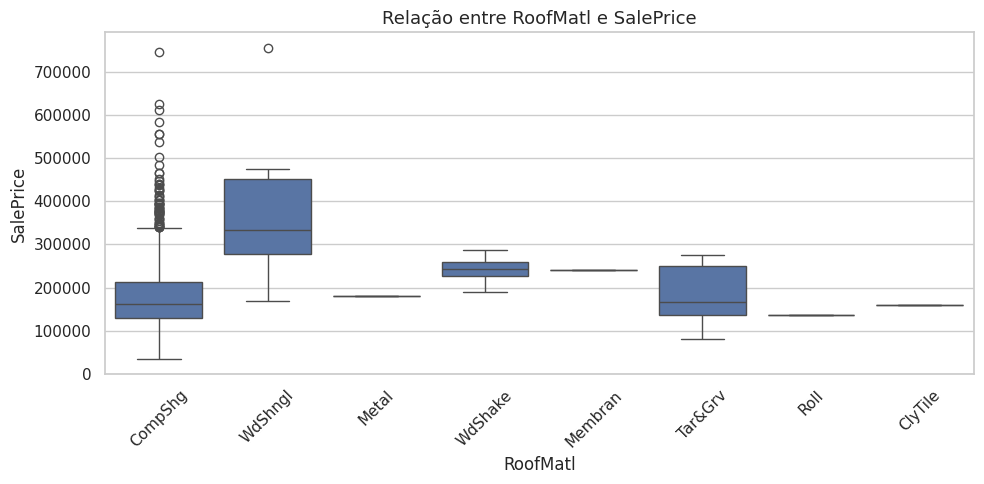

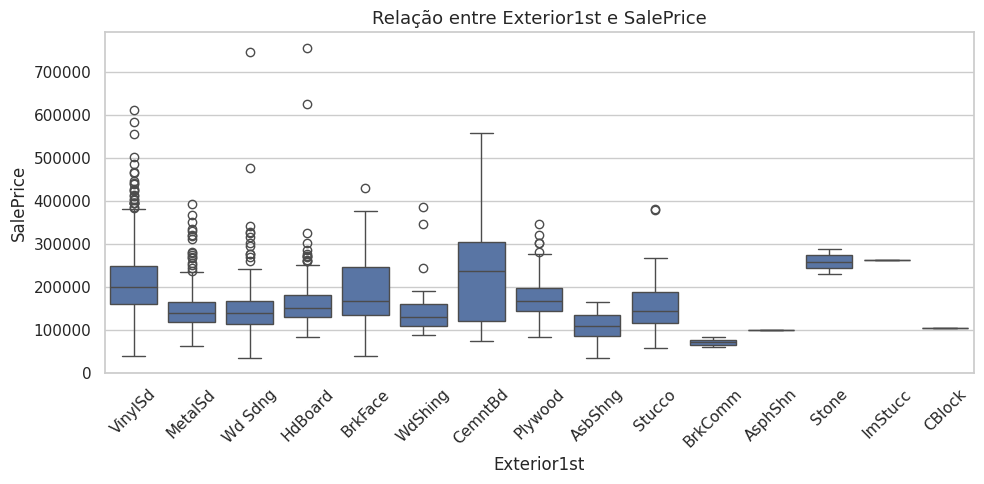

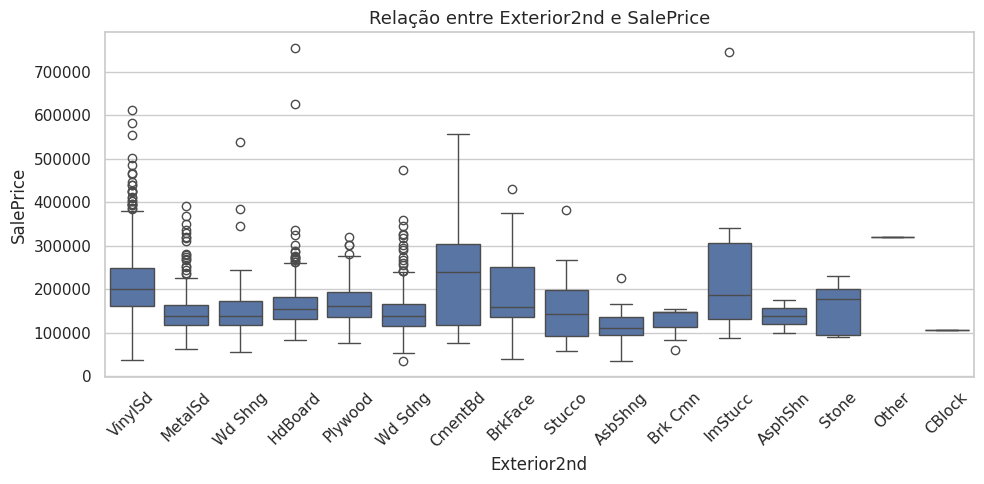

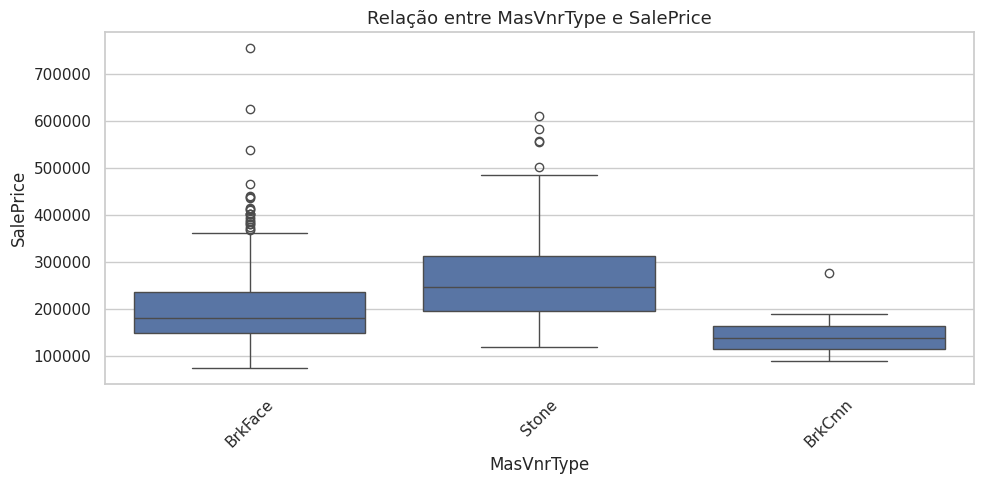

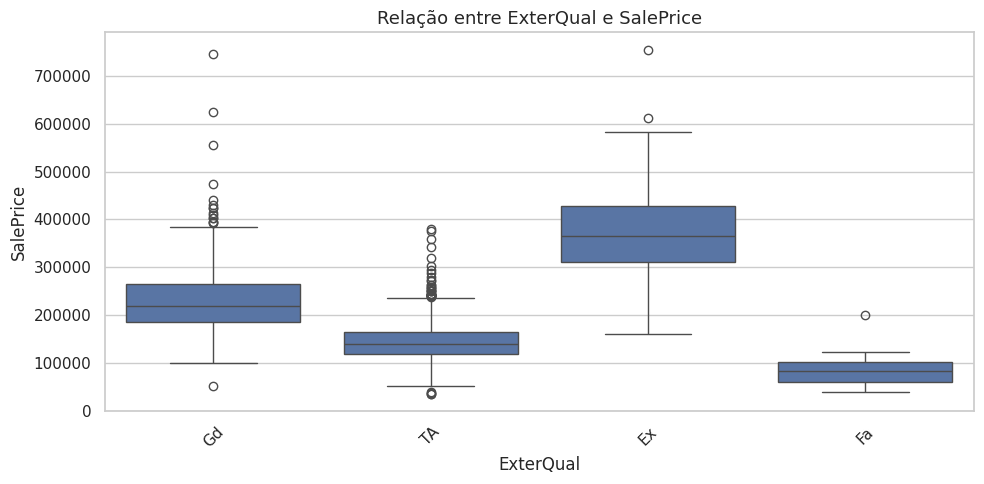

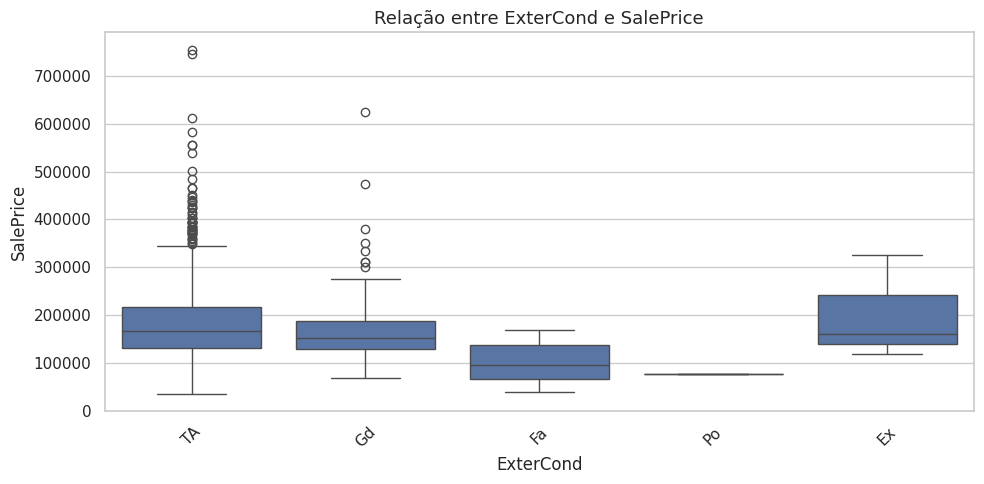

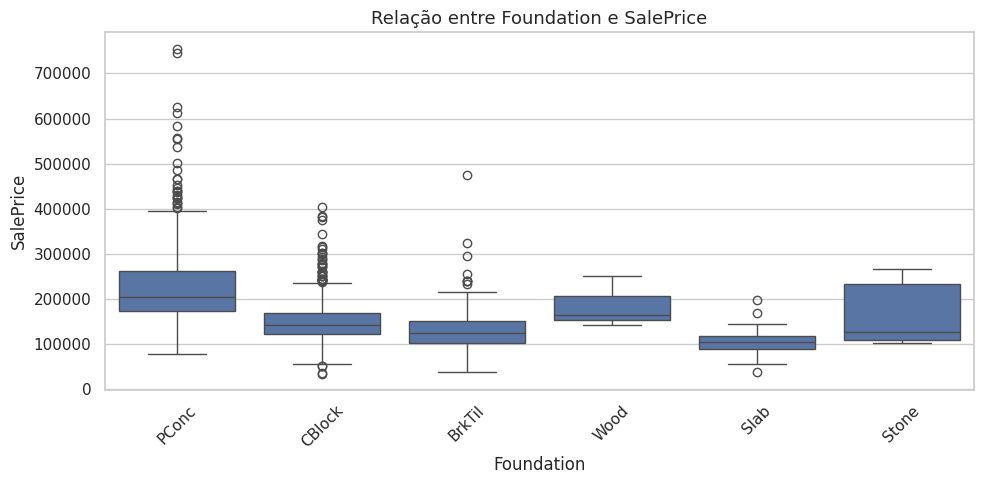

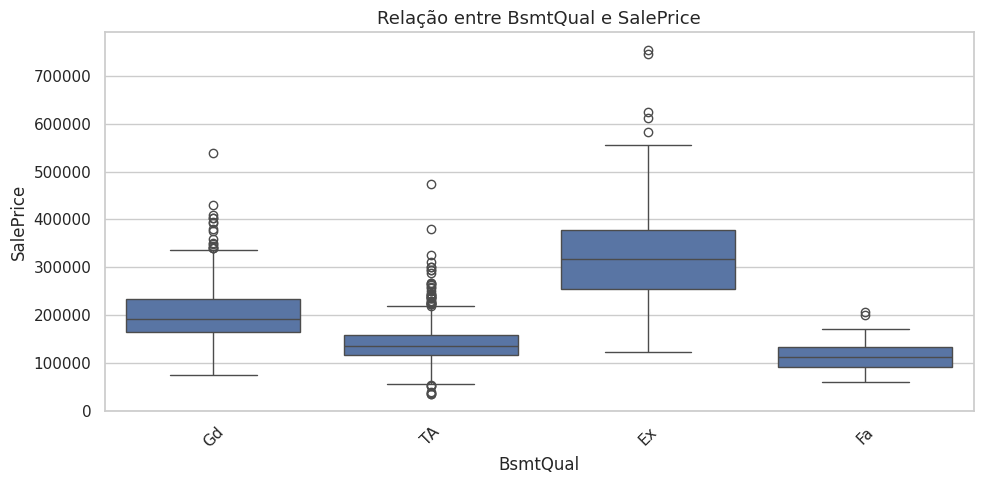

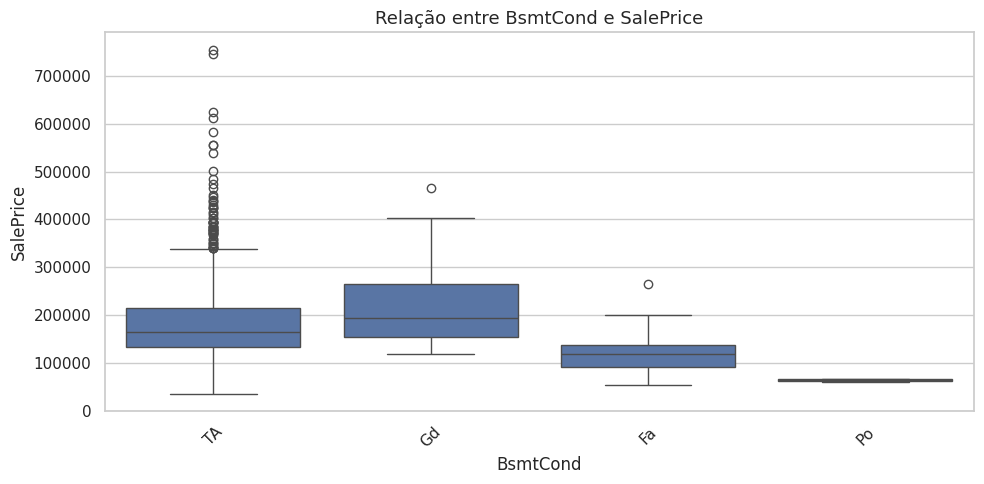

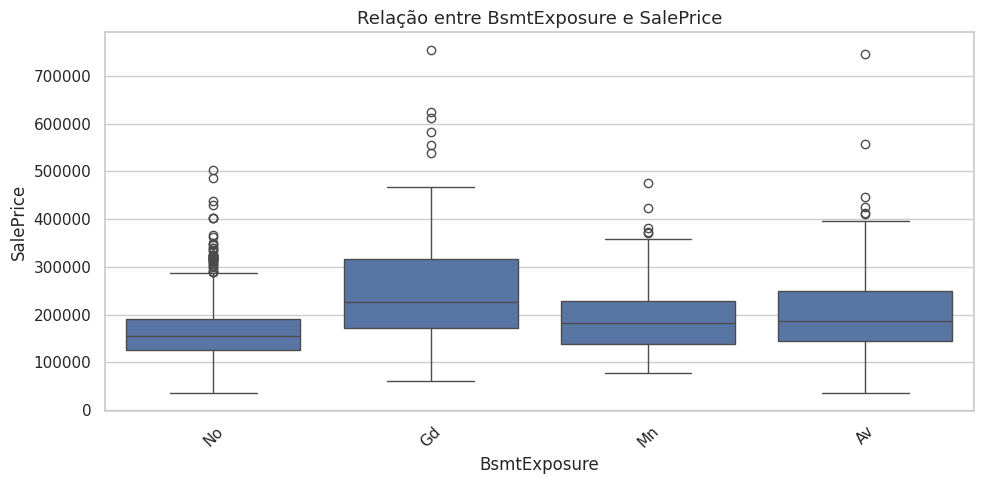

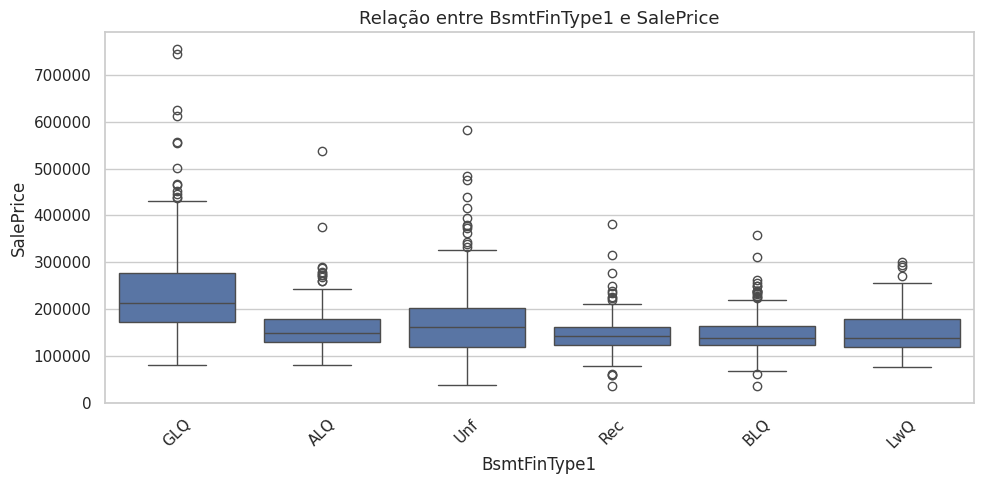

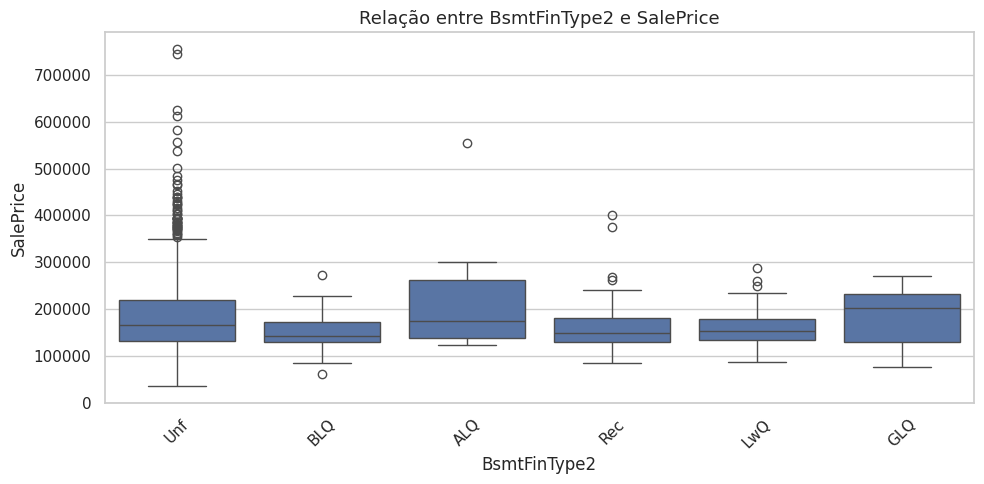

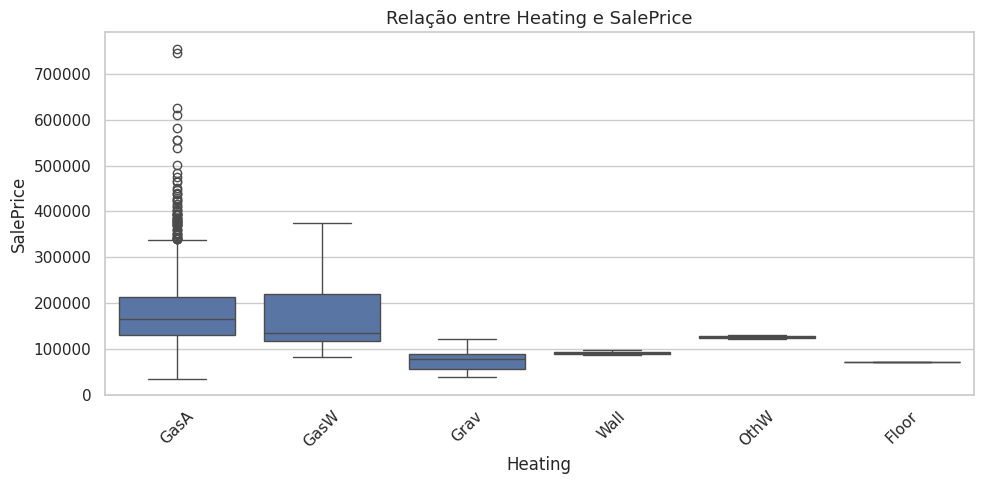

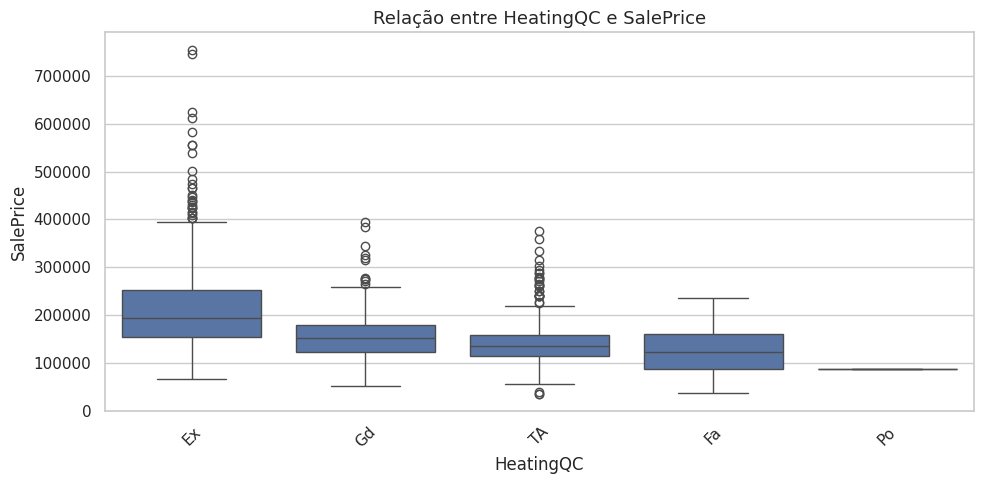

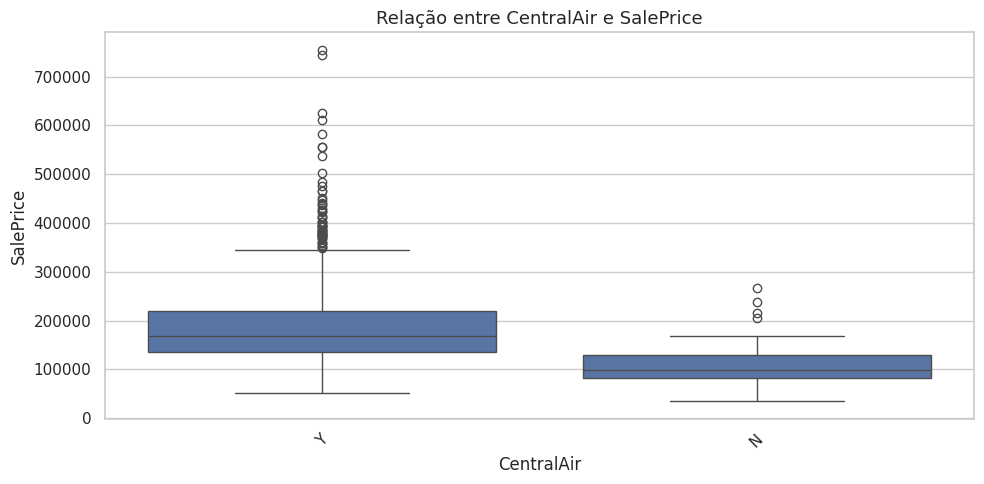

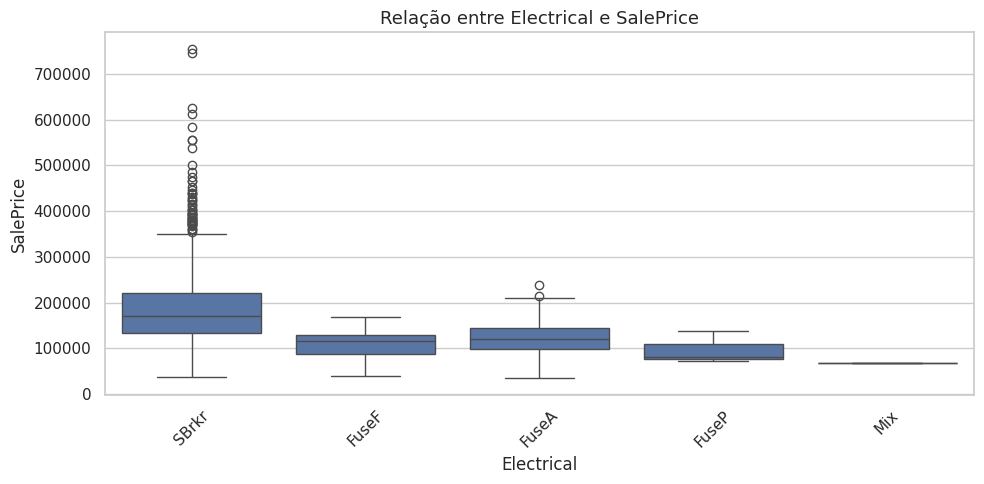

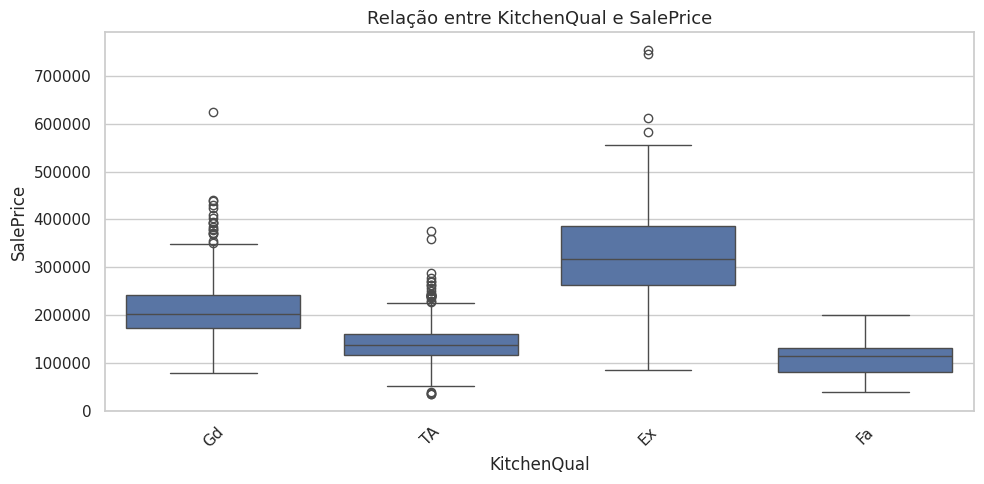

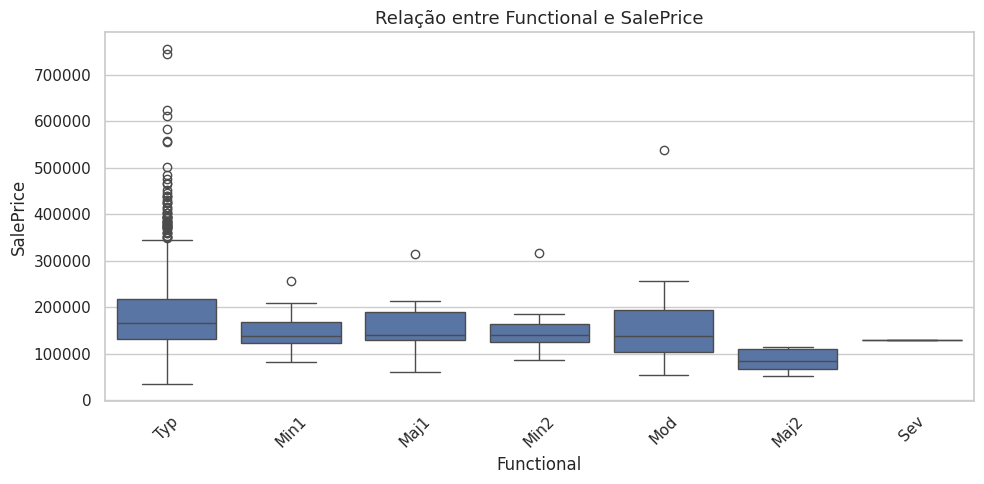

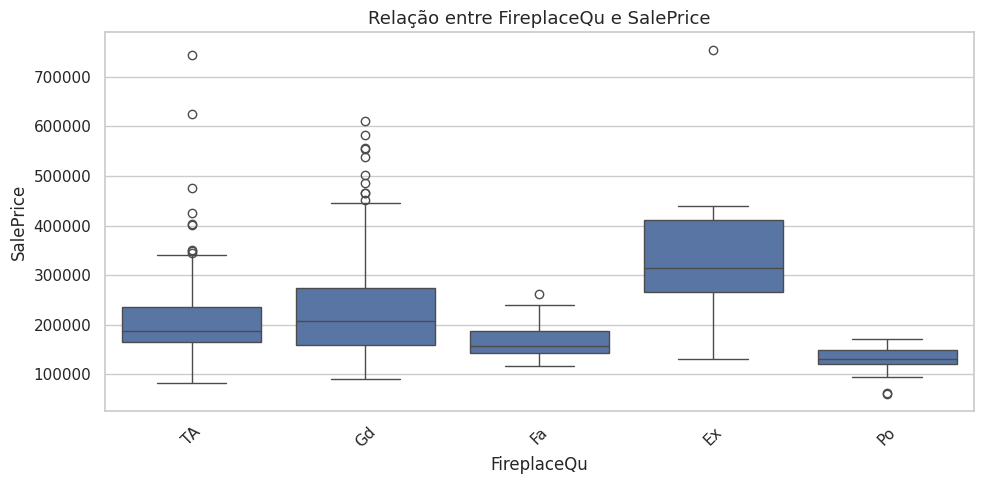

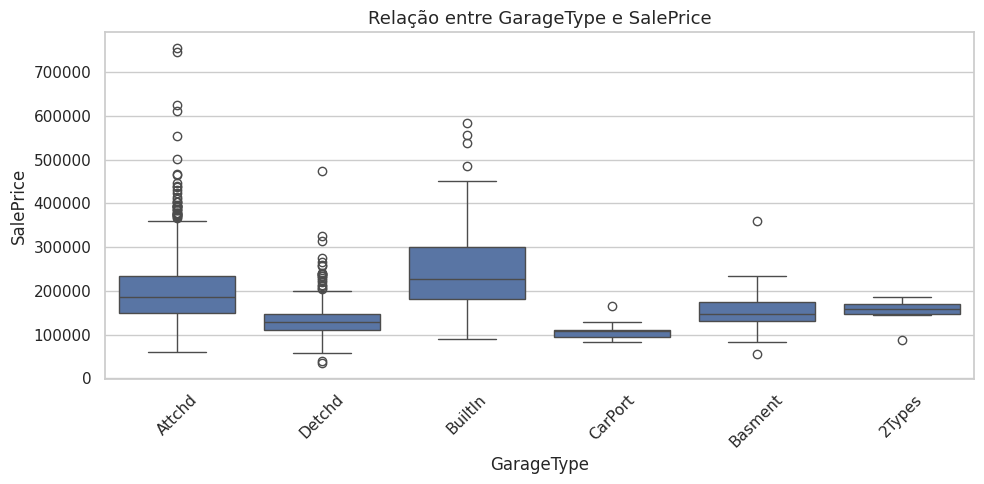

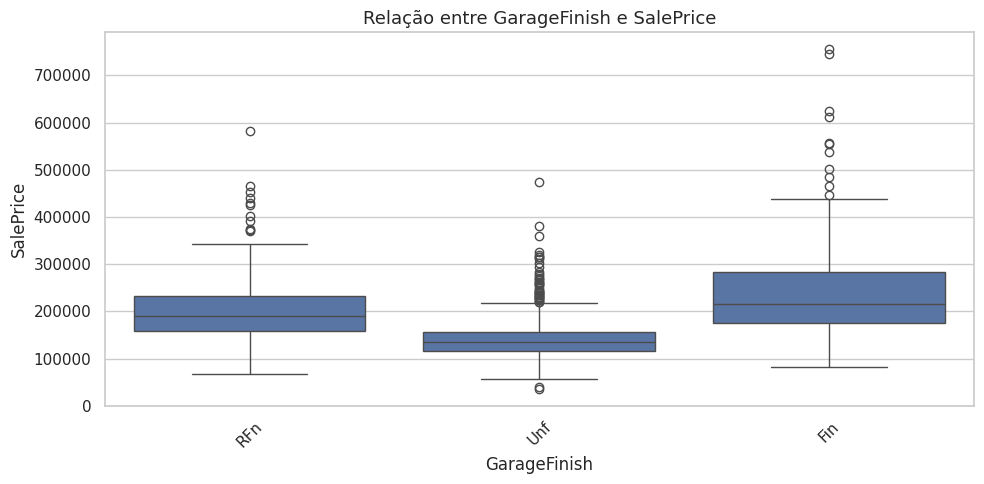

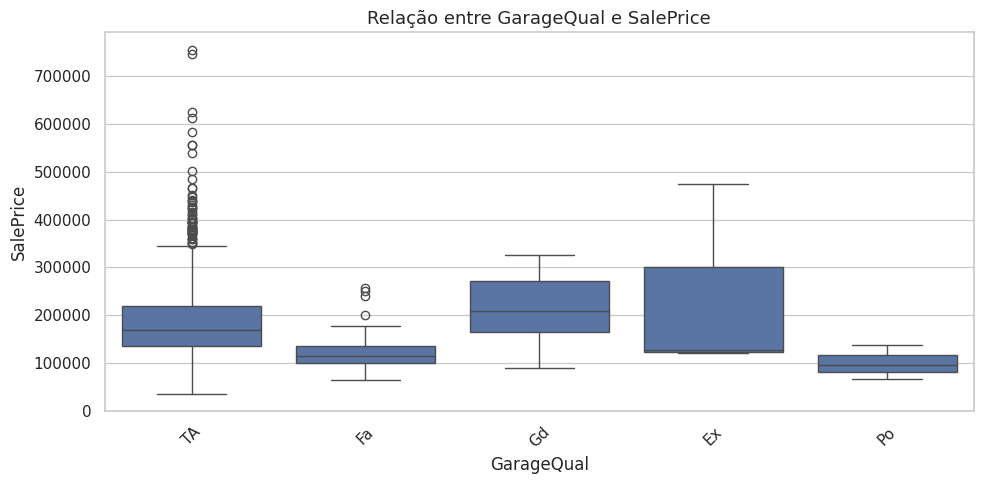

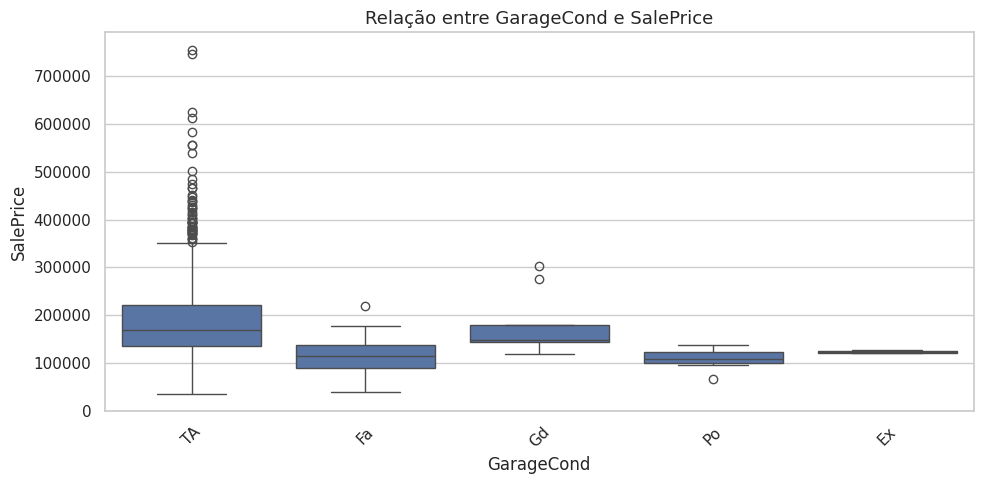

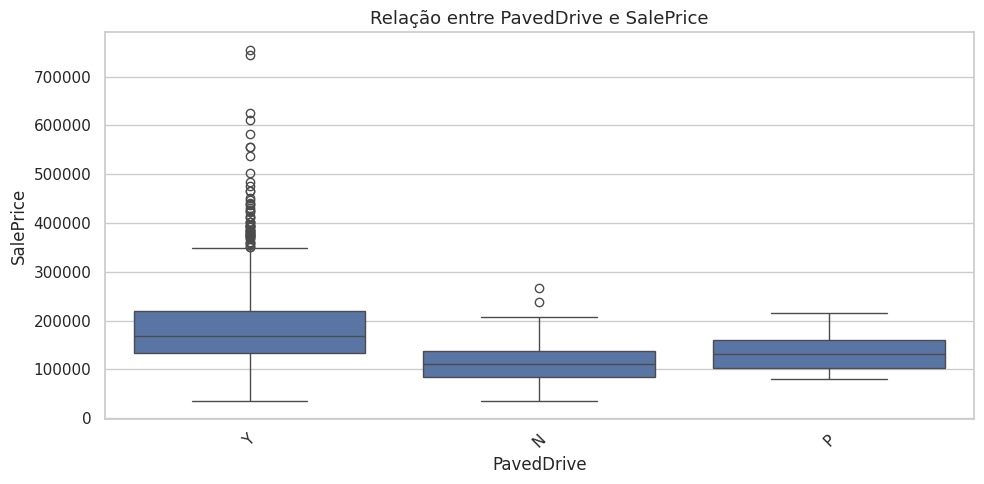

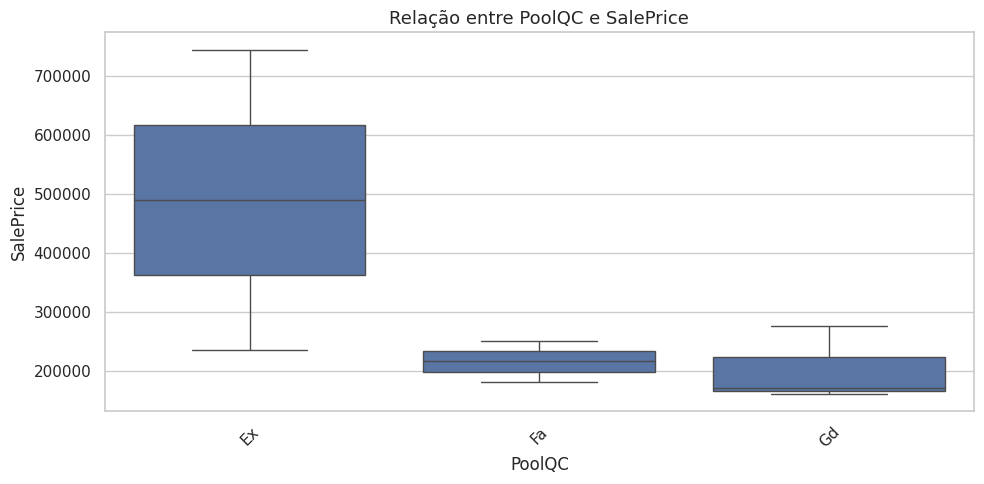

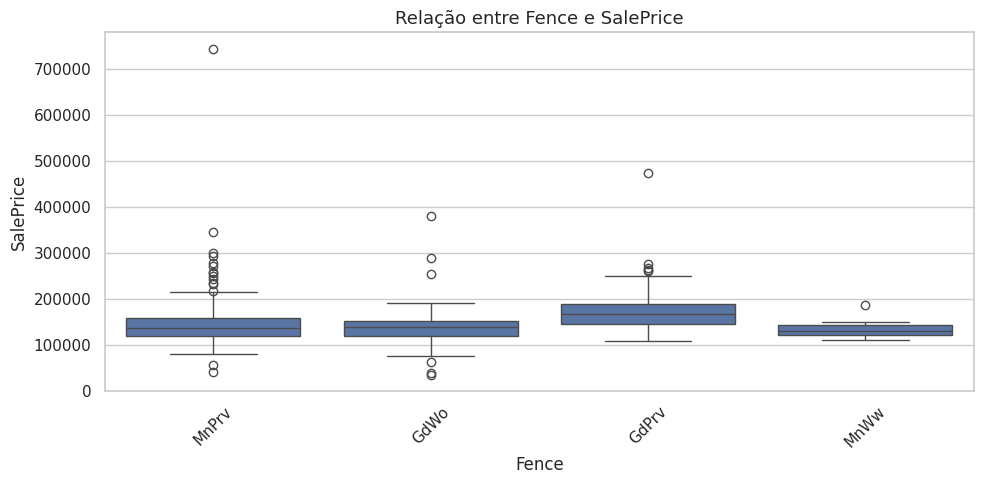

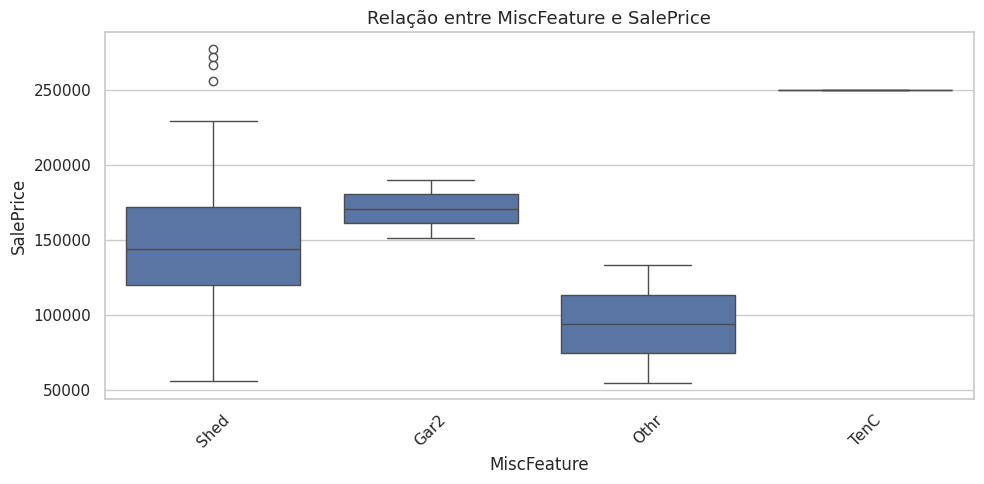

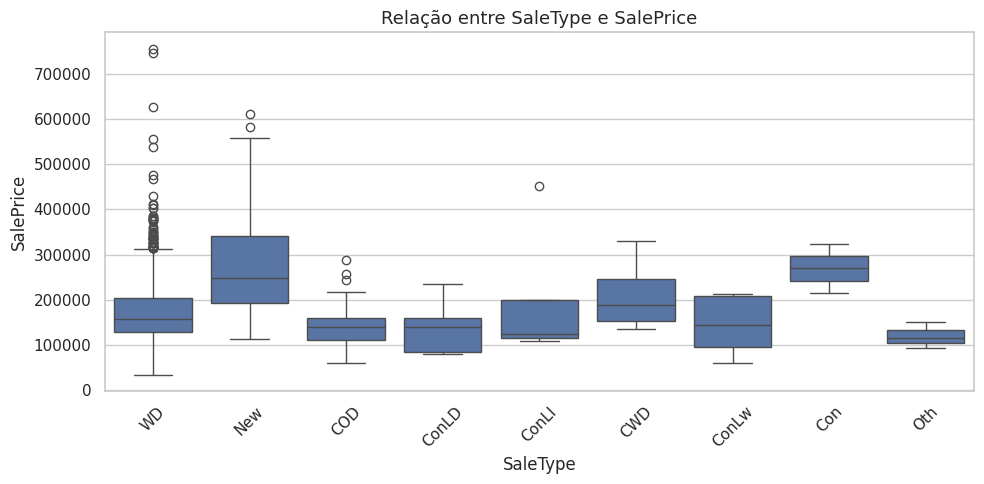

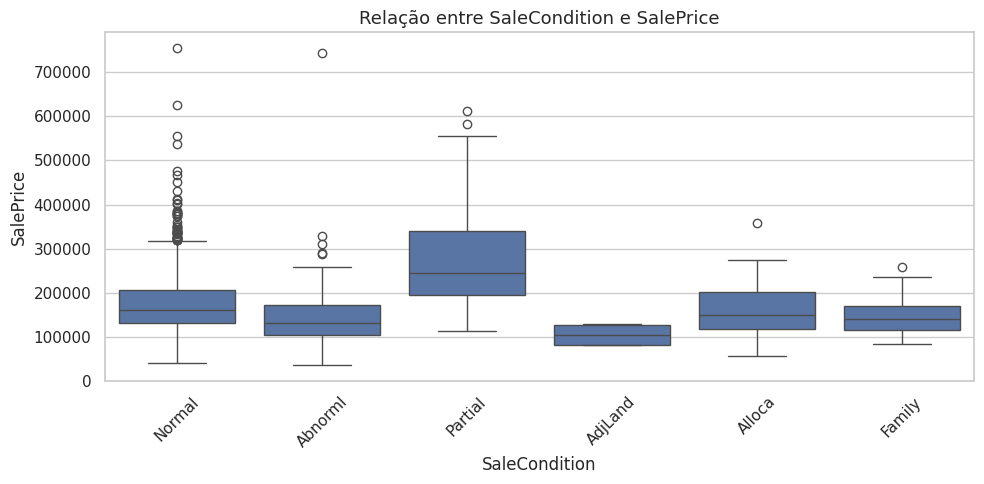

In [ ]:
relevant_cats = categorical_cols

for col in relevant_cats:
    plt.figure(figsize=(10,5))
    sns.boxplot(x=col, y="SalePrice", data=df)
    plt.title(f"Relação entre {col} e SalePrice", fontsize=13)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 5. Analise da correlação das variáveis com SalePrice


In [ ]:
anova_results = []
for col in categorical_cols:
    groups = [group["SalePrice"].values for _, group in df[[col, "SalePrice"]].dropna().groupby(col)]
    if len(groups) > 1:
        f_val, p_val = stats.f_oneway(*groups)
        anova_results.append((col, p_val))

anova_df = pd.DataFrame(anova_results, columns=["Variável", "p_valor"]).sort_values("p_valor")
print("\n🔎 Variáveis categóricas mais correlacionadas com SalePrice (p < 0.001):")
anova_df[anova_df["p_valor"] < 0.001]


🔎 Variáveis categóricas mais correlacionadas com SalePrice (p < 0.001):


,Variável,p_valor
8,Neighborhood,1.558600e-225
18,ExterQual,1.439551e-204
30,KitchenQual,3.032213e-192
21,BsmtQual,9.610615e-186
34,GarageFinish,1.199117e-93
20,Foundation,5.791895e-91
27,HeatingQC,2.667062e-67
33,GarageType,1.247154e-66
24,BsmtFinType1,1.807731e-63
42,SaleCondition,7.988268e-44


In [ ]:
print("\n🔎 Variáveis categóricas parcialmente correlacionadas com SalePrice (0.001 < p < 0.05):")
anova_df[(anova_df["p_valor"] > 0.001) & (anova_df["p_valor"] < 0.05)]



🔎 Variáveis categóricas mais correlacionadas com SalePrice (0.001 < p < 0.05):


,Variável,p_valor
39,Fence,0.002313
25,BsmtFinType2,0.019410
10,Condition2,0.043426


In [ ]:
print("\n🔎 Variáveis categóricas pouco correlacionadas com SalePrice (p > 0.05):")
anova_df[anova_df["p_valor"] > 0.05]


🔎 Variáveis categóricas pouco correlacionadas com SalePrice (p > 0.05):


,Variável,p_valor
40,MiscFeature,0.104728
1,Street,0.117049
7,LandSlope,0.141396
38,PoolQC,0.303985
5,Utilities,0.584717


# 5.1. Variáveis muito correlacinadas por analise visual

In [ ]:
critical_features = [
    "Neighborhood",     # reflete localização → impacto direto no preço
    "KitchenQual",      # qualidade da cozinha é muito relevante
    "ExterQual",        # qualidade externa
    "GarageType",       # tipo/ausência de garagem
    "BsmtQual",         # qualidade do porão
    "CentralAir",       # presença de ar condicionado
    "SaleCondition",    # tipo de venda (Normal, Abnormal, Partial)
    "HeatingQC",        # qualidade do sistema de aquecimento
    "Foundation"        # tipo de fundação
]

## 6. Recomendação de encoding

- **MSZoning:** One-Hot Encoding
- **Street:** Binary Encoding
- **Alley:** One-Hot Encoding + “None”
- **LotShape:** Ordinal Encoding
- **LandContour:** One-Hot Encoding
- **Utilities:** Excluir (baixa variabilidade)
- **LotConfig:** One-Hot Encoding
- **LandSlope:** Ordinal Encoding
- **Neighborhood:** Target Encoding
- **Condition1:** One-Hot Encoding
- **Condition2:** One-Hot Encoding
- **BldgType:** One-Hot Encoding
- **HouseStyle:** One-Hot Encoding
- **RoofStyle:** One-Hot Encoding
- **RoofMatl:** Excluir (baixa variabilidade)
- **Exterior1st:** One-Hot Encoding
- **Exterior2nd:** One-Hot Encoding
- **MasVnrType:** One-Hot Encoding + “None”
- **ExterQual:** Ordinal Encoding
- **ExterCond:** Ordinal Encoding
- **Foundation:** One-Hot Encoding
- **BsmtQual:** Ordinal Encoding + “None”
- **BsmtCond:** Ordinal Encoding + “None”
- **BsmtExposure:** Ordinal Encoding + “None”
- **BsmtFinType1:** Ordinal Encoding + “None”
- **BsmtFinType2:** Ordinal Encoding + “None”
- **Heating:** One-Hot Encoding
- **HeatingQC:** Ordinal Encoding
- **CentralAir:** Binary Encoding
- **Electrical:** One-Hot Encoding
- **KitchenQual:** Ordinal Encoding
- **Functional:** Ordinal Encoding
- **FireplaceQu:** Ordinal Encoding + “None”
- **GarageType:** One-Hot Encoding + “None”
- **GarageFinish:** Ordinal Encoding + “None”
- **GarageQual:** Ordinal Encoding + “None”
- **GarageCond:** Ordinal Encoding + “None”
- **PavedDrive:** Ordinal Encoding
- **PoolQC:** Ordinal Encoding + “None”
- **Fence:** Ordinal Encoding + “None”
- **MiscFeature:** One-Hot Encoding + “None”
- **SaleType:** One-Hot Encoding
- **SaleCondition:** One-Hot Encoding


#7. Conclusão
### Variáveis que exigem mais atenção

#### 1. Variáveis Ordinais de Qualidade (ExterQual, KitchenQual, BsmtQual, HeatingQC, etc.)
- **Por quê:** A relação com `SalePrice` é quase perfeitamente linear. Errar na ordem (ex: usar One-Hot) faria o modelo perder um dos sinais mais fortes do dataset.  
- **Ação:** Garantir que o mapping do Ordinal Encoding siga a lógica correta:
- None = 0
- Po = 1
- Fa = 2
- TA = 3
- Gd = 4
- Ex = 5

#### 2. Variáveis de Alta Cardinalidade (Neighborhood)
- **Por quê:** É um dos preditores mais fortes, mas o One-Hot é inviável.  
- **Ação:** A escolha de Target Encoding é excelente. Certifique-se de aplicá-lo corretamente (ex: dentro de um pipeline de cross-validation) para evitar **data leakage** (vazamento de dados).

#### 3. Variáveis com NaN Significativo (FireplaceQu, Alley, BsmtQual, PoolQC, etc.)
- **Por quê:** O `NaN` não é um dado faltante, é uma informação (ex: "Não tem piscina").  
- **Ação:** A estratégia de preencher com `"None"` e tratar como uma categoria (seja ela ordinal ou nominal) está perfeita.

